# Quantum spectral methods for differential equations: appendix B example

Original authors of paper: Andrew M. Childs, Jin-Peng Liu

Paper: https://link.springer.com/article/10.1007/s00220-020-03699-z

Pre-print: https://arxiv.org/abs/1901.00961

Author of notebook: Óscar Amaro (2023)

__Notes__: See FAQ in the ```README.md```. The authors use Chebyshev-Gauss-Lobatto quadrature nodes, $t_l = \cos (l \pi)$ for $l \in [n + 1]_0$, which has the convenient property that $T_k(t_l) = \cos (k l \pi/n)$ , making it easy to compute the values $x_i (t_l)$. For $n=2$, the interpolating nodes will be $\{\cos(1\pi/n), \cos(2\pi/n) \} = \{0,-1\}$.

Chebyshev polynomials:
- https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebfit.html
- https://github.com/mlazaric/Chebyshev
- https://notes.quantecon.org/submission/5f6a23677312a0001658ee16
- http://hplgit.github.io/num-methods-for-PDEs/doc/pub/approx/sphinx/._main_approx003.html

See also other repo: https://github.com/RePlasma/SFQEDtoolkit

In [81]:
import numpy as np
from numpy import exp, log, sqrt, cos, sin, pi
import matplotlib.pyplot as plt
from scipy.integrate import odeint

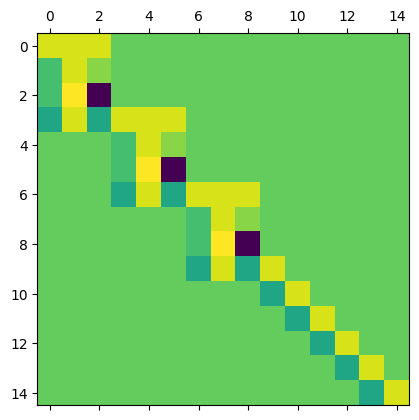

|X> = [0.74137931 0.24137931 0.01724138 0.38347206 0.12485137 0.00891795
 0.19834762 0.06457829 0.00461274 0.13838206 0.13838206 0.13838206
 0.13838206 0.13838206 0.13838206]
reconstruct solution


In [82]:
# main parameters
x0 = 1 # initial condition
A = -1 # linear term, matrix A
T = 2 # final time
d = 1 # overall dimension of the problem
m = 3 # number of time blocks
n = 2 # number of Chebyshev coefficients
p = 1 # to increase measurement probability

# assume A(t) = A, assume tauh = T/m, f(t) = 0
tauh = T/m

def Kh(h_K, h_G): return (-1)**(h_G-h_K) # eq 3.2

def Ah(h,t): # 3.3
    return -0.5*tauh * A

def L1(n):
    mat = np.zeros((n+1,n+1))
    mat[0,:] = 1; mat[:,1] = 1; mat[-1,-1] = -4;
    return mat

def L2(h): # B.5 only submatrix that depends on h
    mat = np.zeros((n+1,n+1))
    mat[1,0] = Ah(h,0);
    mat[1,2] = -Ah(h,0);
    mat[2,0] = Ah(h,-1);
    mat[2,1] = -Ah(h,-1);
    mat[2,2] = Ah(h,-1);
    mat = -mat;
    return mat

def L3(n): # B.6
    mat = np.zeros((n+1,n+1))
    for i in range(n+1):
        mat[0,i] = (-1)**i
    return -mat

def L4(n): # B.7
    mat = np.zeros((n+1,n+1))
    for i in range(n+1):
        mat[i,i] = 1
    for i in range(1,n+1):
        mat[i,i-1] = -1
    return mat

def L5(n): # B.8
    mat = np.zeros((n+1,n+1))
    mat[0,-1] = -1
    return mat

L = np.zeros(( (n+1)*5, (n+1)*5 ))
L[0:3,0:3] = L1(n) + L2(h=0)
L[3:6,3:6] = L1(n) + L2(h=1)
L[6:9,6:9] = L1(n) + L2(h=2)
L[9:12,9:12] = L4(n)
L[12:15,12:15] = L4(n)
#
L[3:6,0:3] = L3(n)
L[6:9,3:6] = L3(n)
L[9:12,6:9] = L3(n)
L[12:15,9:12] = L5(n)
#print(L)

# assuming f(t) = 0
B = np.zeros((n+1)*5); B[0] = x0

# L matrix
plt.matshow(L)
plt.show()

vecX = np.linalg.solve(L, B)
print("|X> =", vecX)

# reconstruct solution from Chebyshev series coefficients
print("reconstruct solution")
solX = np.zeros(m)
tX = np.linspace(0,T,m+1)[1:]
for i in range(m):
    solX[i] = np.polynomial.chebyshev.chebval(-1, vecX[i*m:i*m+3])

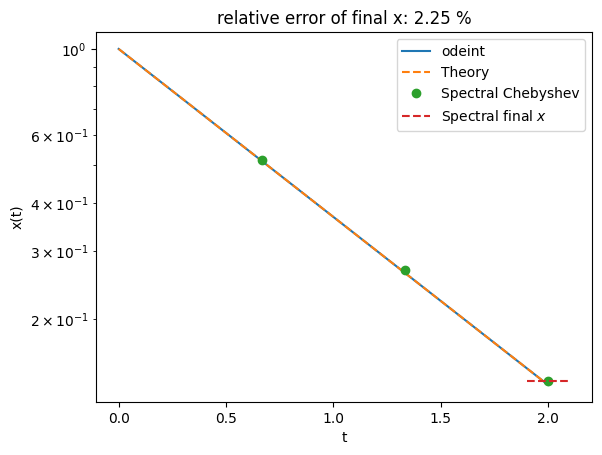

In [84]:
def At(t):
    return A

def odeintfun(y, t):
    dydt = At(t)*y
    return dydt

t = np.linspace(0, T, 101)
sol = odeint(odeintfun, x0, t, args=())
plt.plot(t, sol, label=r'odeint')
plt.plot(t, exp(A*t), '--', label=r'Theory' )
plt.plot(tX, solX, 'o', label=r'Spectral Chebyshev')
plt.plot(np.linspace(0.95*T,1.05*T,len(tX)), tX*0+vecX[-1], '--', label=r'Spectral final $x$')
plt.xlabel(r't')
plt.ylabel(r'x(t)')
plt.yscale('log')
plt.title(r'relative error of final x: {:.2f} %'.format(100*(vecX[-1]-sol[-1,0])/sol[-1,0]))
plt.legend()
#plt.xlim([0,T])
plt.show()